<a href="https://colab.research.google.com/github/jingyi0936/CSE-416/blob/master/k_means_with_text_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
        f.write(r.content)
    
save_file('https://homes.cs.washington.edu/~hschafer/cse416/a6/people_wiki.csv',
          'people_wiki.csv')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
wiki = pd.read_csv('people_wiki.csv')
wiki = wiki.sample(frac=0.1, random_state=0) # Using 10% of the data as to reduce compute time
wiki.head()

,URI,name,text
50034,<http://dbpedia.org/resource/Mauno_J%C3%A4rvel...,Mauno J%C3%A4rvel%C3%A4,mauno jrvel born 25 november 1949 in kaustinen...
39362,<http://dbpedia.org/resource/David_W._Jourdan>,David W. Jourdan,david walter jourdan born december 5 1954 is a...
20786,<http://dbpedia.org/resource/Patrick_Roach>,Patrick Roach,patrick roach born march 4 1969 is a canadian ...
26367,<http://dbpedia.org/resource/Louis_Sauer>,Louis Sauer,louis lou sauer aka louis edward sauer born 19...
14855,<http://dbpedia.org/resource/Marty_Keough>,Marty Keough,richard martin keough born april 14 1934 in oa...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.95)  # ignore words with very high doc frequency
tf_idf = vectorizer.fit_transform(wiki['text'])
words = vectorizer.get_feature_names()

In [ ]:
tf_idf = csr_matrix(tf_idf)

tf_idf.shape

(5907, 112801)

In [ ]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)

In [ ]:
def get_initial_centroids(data, k, seed=None):
    """
    Randomly choose k data points as initial centroids
    """
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
        
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

In [ ]:
from sklearn.metrics import pairwise_distances

# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')
print(dist)

[[1.39996239 1.39958932]
 [1.40386156 1.39754968]
 [1.38421176 1.39682604]
 ...
 [1.40562888 1.39024794]
 [1.39673862 1.38306708]
 [1.40872806 1.40250208]]


In [ ]:
# TODO Fill out this cell
cent= tf_idf[0:3, :]
distances = pairwise_distances(tf_idf, cent, metric = 'euclidean') 
# distances.shape
dist = pairwise_distances(tf_idf[430,], cent[1])
print(dist)

[[1.40319922]]


In [ ]:
# Test Cell
if distances.shape == (5907, 3) and np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


In [ ]:
# TODO Fill out this cell
closest_cluster = np.argmin(distances, axis = 1)
print(closest_cluster)

[0 1 2 ... 2 2 2]


In [ ]:
# Test Cell
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


In [ ]:
# Students should write code here
cen = tf_idf[:3, :]
dis = pairwise_distances(tf_idf, cen, metric = 'euclidean')
cluster_assignment = np.argmin(dis, axis = 1)

In [ ]:
if len(cluster_assignment)==5907 and \
   np.array_equal(np.bincount(cluster_assignment), np.array([515,  440, 4952])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


In [ ]:
# TODO 
def assign_clusters(data, centroids):
    distancee = pairwise_distances(data, centroids, metric='euclidean')
    cluster_assignment = np.argmin(distancee, axis = 1)
    return cluster_assignment

In [ ]:
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 3, 3, 3, 3, 2, 2, 1, 1, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


In [ ]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

In [ ]:
cluster_assignment = assign_clusters(data, centroids)
print(cluster_assignment)

[0 1 0]


In [ ]:
cluster_assignment==1

array([False,  True, False])

In [ ]:
cluster_assignment==0

array([ True, False,  True])

In [ ]:
data[cluster_assignment==1]

array([[0., 0., 0.]])

In [ ]:
data[cluster_assignment==0]

array([[1., 2., 0.],
       [2., 2., 0.]])

In [ ]:
data[cluster_assignment==0].mean(axis=0)

array([1.5, 2. , 0. ])

In [ ]:
# TODO
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
        
    new_centroids = np.array(new_centroids)
    return new_centroids

In [ ]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


In [ ]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
  
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i,:]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data point
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [ ]:
compute_heterogeneity(data, 2, centroids, cluster_assignment)

7.25

In [ ]:
# TODO Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):  
        # Print itereation number
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        centroids = revise_centroids(data, k ,cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment == cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = sum(abs(prev_cluster_assignment - cluster_assignment))
            if verbose:
                print(f'    {num_changed:5d} elements changed their cluster assignment.')  
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [ ]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title(f'Heterogeneity of clustering over time, K={k}')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

0
1
     2036 elements changed their cluster assignment.
2
      654 elements changed their cluster assignment.
3
      376 elements changed their cluster assignment.
4
      264 elements changed their cluster assignment.
5
      112 elements changed their cluster assignment.
6
       37 elements changed their cluster assignment.
7
       10 elements changed their cluster assignment.
8
        6 elements changed their cluster assignment.
9
        2 elements changed their cluster assignment.
10
        2 elements changed their cluster assignment.
11


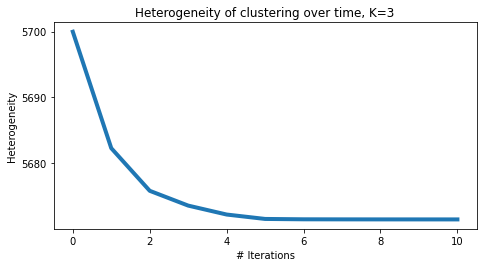

In [ ]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

In [ ]:
occurence = np.bincount(cluster_assignment)
print(occurence)
# [4689  404  814]

[4689  404  814]


In [ ]:
%%time
# ^ Magic command to time how long it takes for this cell to run!
# You can see how long it took with the output that says "Wall time"

k = 10
heterogeneity = {}
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print(f'seed={seed:06d}, heterogeneity={heterogeneity[seed]:.5f}')
    
    sys.stdout.flush()

seed=000000, heterogeneity=5569.17352
seed=020000, heterogeneity=5563.93396
seed=040000, heterogeneity=5562.09533
seed=060000, heterogeneity=5574.80813
seed=080000, heterogeneity=5563.38377
seed=100000, heterogeneity=5565.93209
seed=120000, heterogeneity=5572.40064
CPU times: user 9.31 s, sys: 144 ms, total: 9.46 s
Wall time: 9.46 s


In [ ]:
def smart_initialize(data, k, seed=None):
    """
    Use k-means++ to initialize a good set of centroids
    """
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
        
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    
    # Compute distances from the first centroid chosen to all the other data points
    distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=distances/sum(distances))
        centroids[i] = data[idx,:].toarray()
        
        # Now compute distances from the centroids to all data points
        distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean'),axis=1)
    
    return centroids

In [ ]:
%%time

k = 10
heterogeneity_smart = {}
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print(f'seed={seed:06d}, heterogeneity={heterogeneity_smart[seed]:.5f}')

    sys.stdout.flush()

seed=000000, heterogeneity=5563.24947
seed=020000, heterogeneity=5569.53006
seed=040000, heterogeneity=5563.95996
seed=060000, heterogeneity=5567.74848
seed=080000, heterogeneity=5557.53663
seed=100000, heterogeneity=5559.45113
seed=120000, heterogeneity=5559.02003
CPU times: user 12.8 s, sys: 181 ms, total: 13 s
Wall time: 13.2 s


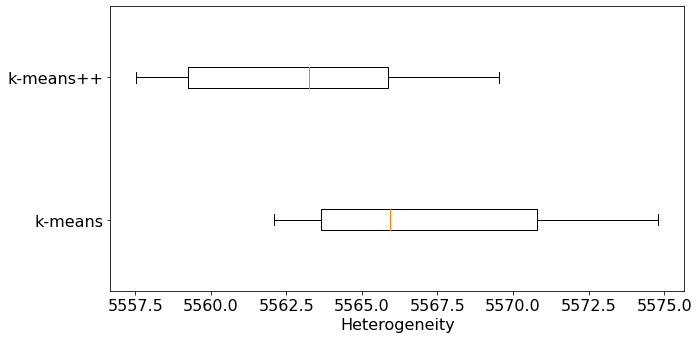

In [ ]:
plt.figure(figsize=(10,5))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.xlabel('Heterogeneity')
plt.tight_layout()

In [ ]:
# TODO
def kmeans_multiple_runs(data, k, maxiter, seeds, verbose=False):
    
    min_heterogeneity_achieved = float('inf')
    final_centroids = None
    final_cluster_assignment = None
    if type(seeds) == int:
        seeds = np.random.randint(low=0, high=10000, size=seeds)
    
    num_runs = len(seeds)
    
    for seed in seeds:
        
        # Use k-means++ initialization with the provided seed: Fill in the blank
        # Set record_heterogeneity=None because we will compute that once at the end.
        initial_centroids = smart_initialize(data, k, seeds)
        
        # Run k-means: Fill in the blank 
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose = False)
        
        # To save time, compute heterogeneity only once in the end
        # Fill in the blank on the right
        seed_heterogeneity = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print(f'seed={seed:06d}, heterogeneity={seed_heterogeneity:.5f}')
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if seed_heterogeneity < min_heterogeneity_achieved:
            min_heterogeneity_achieved = seed_heterogeneity
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

Running k = 2
seed=020000, heterogeneity=5680.07682
seed=040000, heterogeneity=5680.07682
seed=080000, heterogeneity=5680.07682
Running k = 10
seed=020000, heterogeneity=5558.77631
seed=040000, heterogeneity=5558.77631
seed=080000, heterogeneity=5558.77631
Running k = 25
seed=020000, heterogeneity=5477.27655
seed=040000, heterogeneity=5477.27655
seed=080000, heterogeneity=5477.27655
Running k = 50
seed=020000, heterogeneity=5400.32444
seed=040000, heterogeneity=5400.32444
seed=080000, heterogeneity=5400.32444
Running k = 100
seed=020000, heterogeneity=5314.55812
seed=040000, heterogeneity=5314.55812
seed=080000, heterogeneity=5314.55812
CPU times: user 1min 23s, sys: 672 ms, total: 1min 23s
Wall time: 1min 23s


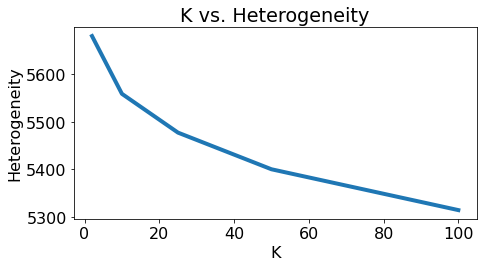

In [ ]:
%%time

def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    """
    Given list of k-values and their heterogeneities, will make a plot
    showing how heterogeneity varies with k.
    """
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

all_centroids = {}
all_cluster_assignment = {}
heterogeneity_values = []
seeds = [20000, 40000, 80000]
k_list = [2, 10, 25, 50, 100]

for k in k_list:
    print(f'Running k = {k}')
    heterogeneity = []
    all_centroids[k], all_cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, maxiter=400,
                                                                       seeds=seeds, verbose=True)
    score = compute_heterogeneity(tf_idf, k, all_centroids[k], all_cluster_assignment[k])
    heterogeneity_values.append(score)

plot_k_vs_heterogeneity(k_list, heterogeneity_values)

In [ ]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, words, 
                                display_docs=5):
    print('=' * 90)

    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print(f'Cluster {c}  ({(cluster_assignment == c).sum()} docs)'),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in range(5): # Print each word along with the TF-IDF weight
            print(f'{words[idx[i]]}:{centroids[c,idx[i]]:.3f}', end=' '),
        print()
        
        if display_docs > 0:
            print()
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For the nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in range(display_docs):
                text = ' '.join(wiki.iloc[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print(f'* {wiki.iloc[nearest_neighbors[i]]["name"]:50s} {distances[nearest_neighbors[i]]:.5f}')
                print(f'  {text[:90]}')
                if len(text) > 90:
                    print(f'  {text[90:180]}')
                print()
        print('=' * 90)

In [ ]:
k = 2
visualize_document_clusters(wiki, tf_idf, all_centroids[k], all_cluster_assignment[k], k, words)

Cluster 0  (4761 docs)
he:0.055 was:0.038 she:0.038 for:0.036 as:0.034 

* Wilson McLean                                      0.94368
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Vipin Sharma                                       0.95052
  vipin sharma is an indian actor born in new delhi he is a graduate of national school of d
  rama new delhi india and the canadian

* Natashia Williams                                  0.95231
  natashia williamsblach born august 2 1978 is an american actress and former wonderbra camp
  aign model who is perhaps best known for her role as shane

* Peter Paret                                        0.95393
  peter paret is a cultural and intellectual historian whose two principal areas of research
   are war and the interaction of art and politics from 18th

* Bhama Srinivasan                                   0.95546
  bhama srinivasan apr

In [ ]:
k = 10
visualize_document_clusters(wiki, tf_idf, all_centroids[k], all_cluster_assignment[k], k, words)

Cluster 0  (794 docs)
he:0.084 was:0.059 as:0.045 for:0.038 from:0.036 

* Doug Naysmith                                      0.93341
  john douglas naysmith born 1 april 1941 is a british labour cooperative politician who was
   the member of parliament mp for bristol north west from

* John Garamendi                                     0.93806
  john raymond garamendi born january 24 1945 is an american rancher businessman politician 
  and member of the democratic party who has represented areas of northern

* Bill Clinton                                       0.93884
  william jefferson bill clinton born william jefferson blythe iii august 19 1946 is an amer
  ican politician who served from 1993 to 2001 as the 42nd

* Jim Elder (politician)                             0.94140
  james peter jim elder born 14 december 1950 is a former australian politician he was a mem
  ber of the legislative assembly of queensland from 1989

* Levin H. Campbell                                  0.9

In [ ]:
np.bincount(all_cluster_assignment[10])

array([ 794,  429,  404,  277, 1234,  504,  904,  174,  911,  276])

In [ ]:
k = 25
visualize_document_clusters(wiki, tf_idf, all_centroids[k], all_cluster_assignment[k], k,
                            words, display_docs=0) # turn off text for brevity

Cluster 0  (351 docs)
he:0.082 was:0.061 election:0.057 party:0.056 as:0.042 
Cluster 1  (46 docs)
tour:0.317 pga:0.243 golf:0.125 he:0.117 his:0.083 
Cluster 2  (45 docs)
air:0.141 force:0.088 command:0.087 commander:0.073 he:0.073 
Cluster 3  (74 docs)
racing:0.137 he:0.080 race:0.074 championship:0.074 car:0.070 
Cluster 4  (208 docs)
was:0.062 he:0.056 that:0.049 his:0.038 on:0.033 
Cluster 5  (94 docs)
radio:0.157 show:0.083 he:0.076 on:0.059 for:0.048 
Cluster 6  (672 docs)
she:0.189 her:0.130 was:0.043 for:0.037 as:0.032 
Cluster 7  (104 docs)
league:0.136 baseball:0.126 he:0.099 season:0.074 major:0.071 
Cluster 8  (219 docs)
law:0.106 he:0.083 as:0.048 was:0.047 from:0.047 
Cluster 9  (171 docs)
hockey:0.084 coach:0.083 basketball:0.078 he:0.077 season:0.064 
Cluster 10  (155 docs)
he:0.056 business:0.044 chairman:0.043 board:0.041 as:0.037 
Cluster 11  (314 docs)
he:0.102 football:0.081 league:0.074 club:0.068 season:0.065 
Cluster 12  (494 docs)
album:0.068 band:0.061 he:0.0

In [ ]:
k=100
visualize_document_clusters(wiki, tf_idf, all_centroids[k], all_cluster_assignment[k], k,
                            words, display_docs=0)

Cluster 0  (23 docs)
election:0.101 gael:0.090 he:0.088 was:0.084 general:0.080 
Cluster 1  (15 docs)
club:0.127 he:0.117 played:0.068 bc:0.060 season:0.059 
Cluster 2  (28 docs)
air:0.209 force:0.102 command:0.097 commander:0.075 naval:0.068 
Cluster 3  (20 docs)
racing:0.170 championship:0.091 rally:0.079 driver:0.068 motocross:0.067 
Cluster 4  (79 docs)
was:0.071 he:0.067 prison:0.049 that:0.048 his:0.043 
Cluster 5  (7 docs)
gary:0.176 detroit:0.110 kilpatrick:0.097 shiels:0.075 sailing:0.069 
Cluster 6  (297 docs)
she:0.225 her:0.114 was:0.045 for:0.037 at:0.034 
Cluster 7  (61 docs)
league:0.137 baseball:0.113 he:0.111 era:0.097 season:0.090 
Cluster 8  (51 docs)
coach:0.251 head:0.103 he:0.069 basketball:0.069 assistant:0.066 
Cluster 9  (55 docs)
hockey:0.256 nhl:0.116 ice:0.084 season:0.083 he:0.075 
Cluster 10  (7 docs)
fresh:0.096 gharda:0.095 chino:0.071 business:0.065 dr:0.054 
Cluster 11  (194 docs)
he:0.105 league:0.082 football:0.065 club:0.062 season:0.062 
Cluster 12

In [ ]:
ans = np.bincount(all_cluster_assignment[100])
len(ans[ans < 44])
# 53

53